In [1]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [2]:
class LineWorld:
    def __init__(self, nb_cells=10, start_cell=1, good_end_cell=9, bad_end_cell=0):
        self.done = None
        self.current_state = start_cell  # État actuel
        self.end_good_state = good_end_cell  # État final
        self.end_bad_state = bad_end_cell
        self.reward = 0.0
        self.num_states = nb_cells  # Nombre total d'états
        self.states = [i for i in range(nb_cells)]
        self.actions = [0, 1]
        self.num_actions = 2  # Nombre total d'actions possibles
        self.line_world = ["_"] * (self.num_states - 1)
        self.line_world.insert(self.current_state, "X")

    def reset(self):
        self.reward = 0.0
        self.done = False
        self.current_state = np.random.randint(1, 8)

    def state_description(self):
        return np.array([self.current_state / (self.num_states - 1) * 2.0 - 1.0])

    def state_dim(self):
        return len(self.state_description())

    def step(self, action):
        # Si l'action est 1, on avance à droite
        if (action == 1) and (self.current_state != self.end_good_state) and (self.current_state != self.end_bad_state):
            self.current_state += 1
            self.reward = 0  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state, "X")
            print(self.line_world)
        # Si l'action est 0, on avance à gauche
        elif (action == 0) and (self.current_state != self.end_good_state) and (
                self.current_state != self.end_bad_state):
            self.current_state -= 1
            self.reward = 0  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state, "X")
            print(self.line_world)
        # Si l'on atteint l'état final, la partie est terminée
        if self.current_state == self.end_good_state:
            self.reward = 1  # Récompense de 1 pour atteindre l'état final
            # print(self.line_world)
            self.done = True
        elif self.current_state == self.end_bad_state:
            self.reward = -1
            # print(self.line_world)
            self.done = True
        return self.current_state, self.reward, self.done

In [5]:
def REINFORCE_with_mean_baseline(env, max_iter_count: int = 10000,
                                  gamma: float = 0.99,
                                  alpha_pi: float = 0.01,
                                  alpha_v: float = 0.01):
    pi = tf.keras.models.Sequential()
    pi.add(tf.keras.layers.Dense(len(env.actions),
                                 activation=tf.keras.activations.softmax,
                                 use_bias=True
                                 ))


    ema_score = 0.0
    ema_nb_steps = 0.0
    first_episode = True

    step = 0
    ema_score_progress = []
    ema_nb_steps_progress = []

    episode_states_buffer = []
    episode_actions_buffer = []
    episode_rewards_buffer = []
    
    mean_baseline = 0.0

    for _ in tqdm(range(max_iter_count)):
        if env.done:
            ### TRAINING TIME !!!
            G = 0.0

            for t in reversed(range(0, len(episode_states_buffer))):
                G = episode_rewards_buffer[t] + gamma * G

                delta = G - mean_baseline
                

                with tf.GradientTape() as tape_pi:
                    pi_s_a_t = pi(np.array([episode_states_buffer[t]]))[0][episode_actions_buffer[t]]
                    log_pi_s_a_t = tf.math.log(pi_s_a_t)

                grads = tape_pi.gradient(log_pi_s_a_t, pi.trainable_variables)

                for (var, grad) in zip(pi.trainable_variables, grads):
                    if grad is not None:
                        var.assign_add(alpha_pi * (gamma ** t) * delta * grad)

            mean_baseline = ((mean_baseline * step) + G) / (step + 1)
            
            if first_episode:
                ema_score = env.reward
                ema_nb_steps = step
                first_episode = False
            else:
                ema_score = (1 - 0.95) * env.reward + 0.95 * ema_score
                ema_nb_steps = (1 - 0.95) * step + 0.95 * ema_nb_steps
                ema_score_progress.append(ema_score)
                ema_nb_steps_progress.append(ema_nb_steps)

            env.reset()
            episode_states_buffer.clear()
            episode_actions_buffer.clear()
            episode_rewards_buffer.clear()
            step = 0

        s = env.state_description()

        episode_states_buffer.append(s)

        aa = env.actions

        pi_s = pi(np.array([s]))[0].numpy()
        allowed_pi_s = pi_s[aa]
        sum_allowed_pi_s = np.sum(allowed_pi_s)
        if sum_allowed_pi_s == 0.0:
            probs = np.ones((len(aa),)) * 1.0 / (len(aa))
        else:
            probs = allowed_pi_s / sum_allowed_pi_s

        a = np.random.choice(aa, p=probs)

        episode_actions_buffer.append(a)

        old_score = env.reward
        env.step(a)
        new_score = env.reward
        r = new_score - old_score

        episode_rewards_buffer.append(r)

        step += 1
    return pi, mean_baseline, ema_score_progress, ema_nb_steps_progress


  0%|▏                                                                             | 21/10000 [00:00<01:30, 110.27it/s]

['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

  0%|▎                                                                             | 36/10000 [00:00<01:32, 107.35it/s]

['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

  1%|▌                                                                             | 73/10000 [00:00<01:22, 119.95it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', 

  1%|▉                                                                            | 115/10000 [00:00<01:01, 161.65it/s]

['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

  1%|█                                                                            | 145/10000 [00:01<01:35, 103.45it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

  2%|█▍                                                                           | 190/10000 [00:01<01:26, 112.94it/s]

['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

  2%|█▋                                                                           | 222/10000 [00:01<01:20, 121.79it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

  2%|█▉                                                                           | 245/10000 [00:02<01:18, 124.74it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']


  3%|██                                                                           | 274/10000 [00:02<01:12, 133.46it/s]

['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

  3%|██▍                                                                          | 310/10000 [00:02<01:04, 150.75it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

  4%|██▋                                                                          | 353/10000 [00:02<00:44, 216.58it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']


  4%|██▉                                                                          | 377/10000 [00:02<01:04, 149.33it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

  4%|███                                                                          | 397/10000 [00:03<01:11, 134.01it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

  5%|███▌                                                                         | 461/10000 [00:03<00:57, 164.87it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

  5%|███▋                                                                         | 482/10000 [00:03<01:03, 150.35it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

  5%|████                                                                         | 529/10000 [00:03<01:08, 138.49it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

  6%|████▎                                                                        | 558/10000 [00:04<01:06, 142.50it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

  6%|████▋                                                                        | 613/10000 [00:04<01:03, 146.73it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

  6%|████▊                                                                        | 632/10000 [00:04<01:04, 144.75it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

  7%|█████                                                                        | 658/10000 [00:04<01:04, 145.68it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

  7%|█████▌                                                                       | 723/10000 [00:05<01:01, 151.18it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

  8%|█████▊                                                                       | 757/10000 [00:05<01:04, 144.40it/s]

['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

  8%|██████                                                                       | 785/10000 [00:05<01:02, 146.49it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

  8%|██████▎                                                                      | 817/10000 [00:05<01:03, 144.29it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', 

  9%|██████▌                                                                      | 859/10000 [00:06<01:02, 145.53it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', 

  9%|██████▊                                                                      | 889/10000 [00:06<01:03, 143.59it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

  9%|███████                                                                      | 922/10000 [00:06<00:59, 152.73it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 10%|███████▎                                                                     | 955/10000 [00:06<01:04, 139.21it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 10%|███████▍                                                                     | 971/10000 [00:06<01:03, 141.34it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 10%|███████▋                                                                     | 998/10000 [00:07<01:03, 142.71it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']


 10%|███████▊                                                                    | 1031/10000 [00:07<01:05, 137.42it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 11%|████████                                                                    | 1060/10000 [00:07<01:15, 118.18it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 11%|████████▏                                                                   | 1076/10000 [00:07<01:09, 127.84it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 11%|████████▍                                                                   | 1108/10000 [00:08<01:13, 121.72it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', 

 11%|████████▌                                                                   | 1134/10000 [00:08<01:10, 125.49it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']


 12%|████████▊                                                                   | 1158/10000 [00:08<00:58, 150.27it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 12%|█████████                                                                   | 1191/10000 [00:08<01:02, 141.78it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 12%|█████████▎                                                                  | 1220/10000 [00:08<01:09, 126.83it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 13%|█████████▌                                                                  | 1263/10000 [00:09<01:05, 133.48it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 13%|█████████▊                                                                  | 1287/10000 [00:09<01:03, 137.00it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 13%|██████████                                                                  | 1320/10000 [00:09<00:48, 177.50it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 13%|██████████▏                                                                 | 1340/10000 [00:09<01:11, 121.49it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 14%|██████████▍                                                                 | 1371/10000 [00:10<01:10, 121.65it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 14%|██████████▋                                                                 | 1400/10000 [00:10<01:10, 121.27it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 14%|██████████▋                                                                 | 1414/10000 [00:10<01:09, 123.08it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 15%|███████████                                                                 | 1453/10000 [00:10<01:08, 125.63it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 15%|███████████▏                                                                | 1467/10000 [00:10<01:07, 127.17it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 15%|███████████▍                                                                | 1505/10000 [00:11<01:03, 133.80it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 15%|███████████▌                                                                | 1523/10000 [00:11<01:02, 136.04it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 16%|███████████▊                                                                | 1559/10000 [00:11<01:00, 139.89it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']


 16%|███████████▉                                                                | 1574/10000 [00:11<01:01, 136.61it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 16%|████████████▏                                                               | 1601/10000 [00:11<01:08, 122.12it/s]

['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', 

 16%|████████████▍                                                               | 1632/10000 [00:12<01:07, 123.35it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 16%|████████████▌                                                               | 1645/10000 [00:12<01:07, 123.47it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 17%|████████████▋                                                               | 1675/10000 [00:12<01:05, 126.31it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 17%|████████████▊                                                               | 1694/10000 [00:12<00:58, 142.88it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 17%|█████████████▏                                                              | 1727/10000 [00:12<01:04, 128.66it/s]


['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_',

 18%|█████████████▎                                                              | 1756/10000 [00:13<01:02, 132.79it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', 

 18%|█████████████▌                                                              | 1784/10000 [00:13<01:05, 125.45it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', 

 18%|█████████████▊                                                              | 1815/10000 [00:13<01:04, 127.33it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 18%|██████████████                                                              | 1846/10000 [00:13<01:05, 124.50it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 19%|██████████████▏                                                             | 1872/10000 [00:14<01:17, 104.31it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 19%|██████████████▎                                                             | 1887/10000 [00:14<01:13, 110.06it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 19%|██████████████▌                                                             | 1914/10000 [00:14<01:13, 109.28it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', 

 20%|██████████████▊                                                             | 1955/10000 [00:14<01:12, 111.11it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 20%|███████████████                                                             | 1984/10000 [00:15<01:09, 114.52it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']


 20%|███████████████▏                                                            | 1996/10000 [00:15<01:16, 104.27it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 20%|███████████████▍                                                            | 2030/10000 [00:15<01:12, 110.62it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 21%|███████████████▋                                                            | 2059/10000 [00:15<01:03, 124.37it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', 

 21%|███████████████▋                                                            | 2072/10000 [00:15<01:09, 114.22it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 21%|███████████████▉                                                            | 2103/10000 [00:16<01:08, 115.67it/s]


['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']


 21%|████████████████▏                                                           | 2128/10000 [00:16<01:13, 106.67it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 21%|████████████████▎                                                           | 2145/10000 [00:16<01:04, 122.49it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 22%|████████████████▋                                                           | 2194/10000 [00:16<01:04, 120.47it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 22%|████████████████▊                                                           | 2213/10000 [00:17<01:00, 128.26it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 22%|█████████████████                                                           | 2240/10000 [00:17<01:06, 117.03it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 23%|█████████████████▎                                                          | 2270/10000 [00:17<00:58, 132.21it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 23%|█████████████████▌                                                          | 2304/10000 [00:17<00:53, 144.43it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 23%|█████████████████▋                                                          | 2335/10000 [00:17<00:57, 133.89it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 24%|█████████████████▉                                                          | 2363/10000 [00:18<01:09, 109.22it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 24%|██████████████████                                                          | 2383/10000 [00:18<01:13, 103.28it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']


 24%|██████████████████▏                                                         | 2398/10000 [00:18<01:07, 112.71it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 24%|██████████████████▍                                                         | 2429/10000 [00:18<00:58, 128.39it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 25%|██████████████████▋                                                         | 2461/10000 [00:19<00:55, 136.02it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 25%|██████████████████▉                                                         | 2492/10000 [00:19<00:53, 139.91it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 25%|███████████████████▏                                                        | 2527/10000 [00:19<00:52, 142.29it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 26%|███████████████████▍                                                        | 2563/10000 [00:19<00:51, 145.27it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 26%|███████████████████▌                                                        | 2580/10000 [00:19<00:53, 139.33it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 26%|███████████████████▉                                                        | 2619/10000 [00:20<00:50, 144.86it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 26%|████████████████████                                                        | 2635/10000 [00:20<00:49, 148.63it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 27%|████████████████████▎                                                       | 2669/10000 [00:20<00:50, 144.25it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 27%|████████████████████▌                                                       | 2699/10000 [00:20<00:50, 144.68it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 27%|████████████████████▋                                                       | 2729/10000 [00:20<00:51, 141.00it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 27%|████████████████████▉                                                       | 2749/10000 [00:21<00:50, 143.09it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 28%|█████████████████████▏                                                      | 2781/10000 [00:21<00:51, 141.35it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 28%|█████████████████████▎                                                      | 2798/10000 [00:21<00:50, 142.18it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 28%|█████████████████████▌                                                      | 2832/10000 [00:21<00:49, 144.10it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 29%|█████████████████████▋                                                      | 2851/10000 [00:21<00:50, 142.28it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 29%|█████████████████████▉                                                      | 2892/10000 [00:21<00:48, 146.09it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 29%|██████████████████████▎                                                     | 2929/10000 [00:22<00:49, 143.89it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 29%|██████████████████████▍                                                     | 2946/10000 [00:22<00:49, 142.93it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 30%|██████████████████████▋                                                     | 2982/10000 [00:22<00:48, 145.21it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 30%|██████████████████████▉                                                     | 3012/10000 [00:22<00:48, 145.05it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 30%|███████████████████████                                                     | 3027/10000 [00:22<00:50, 138.82it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 31%|███████████████████████▎                                                    | 3062/10000 [00:23<00:46, 149.54it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 31%|███████████████████████▌                                                    | 3094/10000 [00:23<00:49, 140.94it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 31%|███████████████████████▊                                                    | 3125/10000 [00:23<00:48, 141.92it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 31%|███████████████████████▉                                                    | 3145/10000 [00:23<00:47, 143.31it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 32%|████████████████████████▏                                                   | 3177/10000 [00:23<00:47, 143.05it/s]

['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', 

 32%|████████████████████████▍                                                   | 3212/10000 [00:24<00:46, 144.74it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 32%|████████████████████████▋                                                   | 3243/10000 [00:24<00:46, 145.81it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 33%|████████████████████████▉                                                   | 3275/10000 [00:24<00:46, 145.28it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 33%|█████████████████████████▏                                                  | 3307/10000 [00:24<00:45, 145.86it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', 

 34%|█████████████████████████▍                                                  | 3354/10000 [00:25<00:45, 144.85it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 34%|█████████████████████████▌                                                  | 3370/10000 [00:25<00:46, 143.03it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 34%|█████████████████████████▊                                                  | 3404/10000 [00:25<00:43, 152.90it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 34%|██████████████████████████▏                                                 | 3440/10000 [00:25<00:42, 155.32it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 35%|██████████████████████████▍                                                 | 3472/10000 [00:26<00:47, 137.94it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 35%|██████████████████████████▌                                                 | 3487/10000 [00:26<00:46, 141.04it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 35%|██████████████████████████▊                                                 | 3526/10000 [00:26<00:46, 139.22it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 36%|███████████████████████████                                                 | 3560/10000 [00:26<00:43, 149.68it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 36%|███████████████████████████▏                                                | 3576/10000 [00:26<00:44, 145.04it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', 

 36%|███████████████████████████▍                                                | 3607/10000 [00:26<00:45, 139.17it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 36%|███████████████████████████▋                                                | 3639/10000 [00:27<00:46, 137.80it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 37%|███████████████████████████▉                                                | 3674/10000 [00:27<00:44, 143.00it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 37%|████████████████████████████                                                | 3694/10000 [00:27<00:43, 144.02it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 37%|████████████████████████████▎                                               | 3725/10000 [00:27<00:43, 143.86it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 37%|████████████████████████████▍                                               | 3743/10000 [00:27<00:43, 142.83it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 38%|████████████████████████████▋                                               | 3776/10000 [00:28<00:43, 143.38it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 38%|████████████████████████████▉                                               | 3811/10000 [00:28<00:42, 145.75it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', 

 38%|█████████████████████████████▏                                              | 3842/10000 [00:28<00:43, 140.49it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 39%|█████████████████████████████▎                                              | 3864/10000 [00:28<00:37, 161.56it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 39%|█████████████████████████████▌                                              | 3897/10000 [00:28<00:43, 141.12it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 39%|█████████████████████████████▉                                              | 3931/10000 [00:29<00:44, 137.62it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 39%|██████████████████████████████                                              | 3948/10000 [00:29<00:43, 139.14it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 40%|██████████████████████████████▎                                             | 3989/10000 [00:29<00:40, 146.80it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 40%|██████████████████████████████▌                                             | 4020/10000 [00:29<00:41, 143.41it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 40%|██████████████████████████████▋                                             | 4035/10000 [00:29<00:43, 138.18it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 41%|██████████████████████████████▉                                             | 4068/10000 [00:30<00:42, 139.54it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 41%|███████████████████████████████▏                                            | 4099/10000 [00:30<00:41, 142.09it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 41%|███████████████████████████████▍                                            | 4131/10000 [00:30<00:41, 142.50it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 42%|███████████████████████████████▋                                            | 4166/10000 [00:30<00:40, 143.18it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 42%|███████████████████████████████▊                                            | 4181/10000 [00:30<00:41, 138.73it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 42%|████████████████████████████████                                            | 4212/10000 [00:31<00:41, 138.16it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 42%|████████████████████████████████▎                                           | 4247/10000 [00:31<00:40, 142.04it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 43%|████████████████████████████████▍                                           | 4265/10000 [00:31<00:40, 141.95it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 43%|████████████████████████████████▋                                           | 4304/10000 [00:31<00:34, 166.64it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 43%|████████████████████████████████▊                                           | 4321/10000 [00:31<00:41, 136.18it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 44%|█████████████████████████████████                                           | 4354/10000 [00:32<00:37, 149.12it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 44%|█████████████████████████████████▎                                          | 4385/10000 [00:32<00:41, 136.63it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 44%|█████████████████████████████████▍                                          | 4405/10000 [00:32<00:40, 139.04it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 44%|█████████████████████████████████▊                                          | 4442/10000 [00:32<00:37, 149.15it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 45%|██████████████████████████████████                                          | 4475/10000 [00:33<00:39, 139.81it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 45%|██████████████████████████████████▎                                         | 4508/10000 [00:33<00:39, 140.38it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 45%|██████████████████████████████████▎                                         | 4523/10000 [00:33<00:38, 141.42it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 46%|██████████████████████████████████▋                                         | 4557/10000 [00:33<00:38, 141.80it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 46%|██████████████████████████████████▉                                         | 4591/10000 [00:33<00:36, 149.15it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', 

 46%|███████████████████████████████████▏                                        | 4622/10000 [00:34<00:37, 143.78it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', 

 47%|███████████████████████████████████▎                                        | 4654/10000 [00:34<00:38, 138.36it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 47%|███████████████████████████████████▌                                        | 4687/10000 [00:34<00:37, 142.16it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 47%|███████████████████████████████████▋                                        | 4702/10000 [00:34<00:37, 143.12it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', 

 47%|████████████████████████████████████                                        | 4739/10000 [00:34<00:35, 148.38it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', 

 48%|████████████████████████████████████▎                                       | 4770/10000 [00:35<00:34, 150.67it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 48%|████████████████████████████████████▍                                       | 4801/10000 [00:35<00:36, 141.80it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 48%|████████████████████████████████████▊                                       | 4837/10000 [00:35<00:36, 141.07it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 49%|████████████████████████████████████▉                                       | 4856/10000 [00:35<00:36, 141.99it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 49%|█████████████████████████████████████▏                                      | 4889/10000 [00:35<00:35, 143.95it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 49%|█████████████████████████████████████▍                                      | 4919/10000 [00:36<00:35, 142.74it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 49%|█████████████████████████████████████▍                                      | 4934/10000 [00:36<00:34, 144.75it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 50%|█████████████████████████████████████▋                                      | 4964/10000 [00:36<00:35, 142.65it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 50%|█████████████████████████████████████▉                                      | 4996/10000 [00:36<00:34, 144.22it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 50%|██████████████████████████████████████▏                                     | 5027/10000 [00:36<00:35, 140.05it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 51%|██████████████████████████████████████▍                                     | 5063/10000 [00:37<00:34, 142.17it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 51%|██████████████████████████████████████▌                                     | 5082/10000 [00:37<00:34, 141.03it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 51%|██████████████████████████████████████▊                                     | 5114/10000 [00:37<00:33, 145.79it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 51%|███████████████████████████████████████                                     | 5144/10000 [00:37<00:34, 138.99it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 52%|███████████████████████████████████████▏                                    | 5164/10000 [00:37<00:31, 155.26it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 52%|███████████████████████████████████████▌                                    | 5199/10000 [00:38<00:34, 137.99it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', 

 52%|███████████████████████████████████████▋                                    | 5229/10000 [00:38<00:34, 139.74it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 53%|███████████████████████████████████████▉                                    | 5254/10000 [00:38<00:27, 169.51it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 53%|████████████████████████████████████████                                    | 5272/10000 [00:38<00:35, 132.56it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 53%|████████████████████████████████████████▎                                   | 5308/10000 [00:38<00:33, 141.82it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 53%|████████████████████████████████████████▌                                   | 5339/10000 [00:39<00:32, 143.44it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 54%|████████████████████████████████████████▊                                   | 5373/10000 [00:39<00:33, 139.22it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 54%|████████████████████████████████████████▉                                   | 5388/10000 [00:39<00:32, 140.40it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 54%|█████████████████████████████████████████▏                                  | 5423/10000 [00:39<00:31, 143.35it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 55%|█████████████████████████████████████████▍                                  | 5456/10000 [00:39<00:31, 144.79it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 55%|█████████████████████████████████████████▌                                  | 5472/10000 [00:40<00:32, 138.76it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', 

 55%|█████████████████████████████████████████▊                                  | 5502/10000 [00:40<00:31, 142.39it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 55%|██████████████████████████████████████████                                  | 5534/10000 [00:40<00:31, 139.78it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', 

 56%|██████████████████████████████████████████▎                                 | 5565/10000 [00:40<00:30, 146.89it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 56%|██████████████████████████████████████████▌                                 | 5594/10000 [00:40<00:32, 136.45it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 56%|██████████████████████████████████████████▋                                 | 5611/10000 [00:41<00:31, 138.46it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 56%|██████████████████████████████████████████▉                                 | 5642/10000 [00:41<00:31, 139.82it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 57%|███████████████████████████████████████████▏                                | 5675/10000 [00:41<00:31, 138.08it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 57%|███████████████████████████████████████████▏                                | 5690/10000 [00:41<00:31, 138.29it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 57%|███████████████████████████████████████████▍                                | 5721/10000 [00:41<00:29, 143.89it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 58%|███████████████████████████████████████████▋                                | 5755/10000 [00:42<00:29, 142.22it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 58%|███████████████████████████████████████████▉                                | 5786/10000 [00:42<00:29, 141.77it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 58%|████████████████████████████████████████████                                | 5802/10000 [00:42<00:30, 139.84it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 58%|████████████████████████████████████████████▍                               | 5839/10000 [00:42<00:29, 143.08it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 59%|████████████████████████████████████████████▌                               | 5858/10000 [00:42<00:29, 142.32it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 59%|████████████████████████████████████████████▊                               | 5894/10000 [00:43<00:28, 143.69it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 59%|████████████████████████████████████████████▉                               | 5910/10000 [00:43<00:27, 147.79it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 59%|█████████████████████████████████████████████▏                              | 5944/10000 [00:43<00:29, 139.37it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 60%|█████████████████████████████████████████████▍                              | 5978/10000 [00:43<00:28, 141.92it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 60%|█████████████████████████████████████████████▌                              | 5996/10000 [00:43<00:28, 142.56it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 60%|█████████████████████████████████████████████▊                              | 6031/10000 [00:43<00:27, 143.06it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 61%|██████████████████████████████████████████████                              | 6061/10000 [00:44<00:27, 142.37it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', 

 61%|██████████████████████████████████████████████▏                             | 6076/10000 [00:44<00:28, 136.64it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 61%|██████████████████████████████████████████████▍                             | 6111/10000 [00:44<00:27, 141.52it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 61%|██████████████████████████████████████████████▌                             | 6128/10000 [00:44<00:27, 140.16it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 62%|██████████████████████████████████████████████▊                             | 6157/10000 [00:44<00:28, 135.45it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 62%|███████████████████████████████████████████████                             | 6190/10000 [00:45<00:26, 146.45it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 62%|███████████████████████████████████████████████▎                            | 6219/10000 [00:45<00:30, 124.41it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 62%|███████████████████████████████████████████████▎                            | 6233/10000 [00:45<00:30, 123.65it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 63%|███████████████████████████████████████████████▋                            | 6267/10000 [00:45<00:30, 122.08it/s]

['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 63%|███████████████████████████████████████████████▊                            | 6285/10000 [00:45<00:29, 124.98it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 63%|███████████████████████████████████████████████▉                            | 6313/10000 [00:46<00:29, 126.57it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 63%|████████████████████████████████████████████████                            | 6326/10000 [00:46<00:28, 127.47it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 64%|████████████████████████████████████████████████▎                           | 6356/10000 [00:46<00:28, 126.82it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 64%|████████████████████████████████████████████████▌                           | 6387/10000 [00:46<00:29, 121.61it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 64%|████████████████████████████████████████████████▋                           | 6400/10000 [00:46<00:30, 116.31it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 64%|████████████████████████████████████████████████▊                           | 6427/10000 [00:47<00:30, 118.89it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 65%|█████████████████████████████████████████████████                           | 6458/10000 [00:47<00:29, 122.08it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 65%|█████████████████████████████████████████████████▎                          | 6488/10000 [00:47<00:29, 120.87it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 65%|█████████████████████████████████████████████████▍                          | 6505/10000 [00:47<00:28, 122.48it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 65%|█████████████████████████████████████████████████▋                          | 6535/10000 [00:47<00:28, 123.26it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 66%|█████████████████████████████████████████████████▊                          | 6550/10000 [00:48<00:28, 121.10it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 66%|██████████████████████████████████████████████████                          | 6579/10000 [00:48<00:28, 119.63it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']


 66%|██████████████████████████████████████████████████▏                         | 6606/10000 [00:48<00:28, 120.43it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 66%|██████████████████████████████████████████████████▎                         | 6622/10000 [00:48<00:25, 130.67it/s]

['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 66%|██████████████████████████████████████████████████▌                         | 6650/10000 [00:48<00:26, 128.51it/s]

['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 67%|██████████████████████████████████████████████████▋                         | 6677/10000 [00:49<00:28, 118.53it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 67%|██████████████████████████████████████████████████▊                         | 6691/10000 [00:49<00:27, 118.26it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 67%|███████████████████████████████████████████████████                         | 6720/10000 [00:49<00:25, 130.87it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 68%|███████████████████████████████████████████████████▎                        | 6751/10000 [00:49<00:24, 130.63it/s]


['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_',

 68%|███████████████████████████████████████████████████▍                        | 6765/10000 [00:49<00:26, 122.25it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 68%|███████████████████████████████████████████████████▌                        | 6785/10000 [00:49<00:26, 122.39it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 68%|███████████████████████████████████████████████████▊                        | 6822/10000 [00:50<00:24, 130.77it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 69%|████████████████████████████████████████████████████                        | 6856/10000 [00:50<00:23, 134.51it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 69%|████████████████████████████████████████████████████▎                       | 6875/10000 [00:50<00:22, 136.96it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 69%|████████████████████████████████████████████████████▌                       | 6914/10000 [00:50<00:21, 145.63it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', 

 69%|████████████████████████████████████████████████████▊                       | 6944/10000 [00:51<00:22, 138.05it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 70%|█████████████████████████████████████████████████████                       | 6981/10000 [00:51<00:19, 155.98it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 70%|█████████████████████████████████████████████████████▏                      | 6997/10000 [00:51<00:20, 148.96it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 70%|█████████████████████████████████████████████████████▍                      | 7028/10000 [00:51<00:20, 141.88it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', 

 71%|█████████████████████████████████████████████████████▋                      | 7058/10000 [00:51<00:21, 138.37it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 71%|█████████████████████████████████████████████████████▉                      | 7093/10000 [00:52<00:20, 139.24it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 71%|██████████████████████████████████████████████████████                      | 7112/10000 [00:52<00:20, 140.06it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 71%|██████████████████████████████████████████████████████▎                     | 7146/10000 [00:52<00:20, 140.35it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 72%|██████████████████████████████████████████████████████▌                     | 7178/10000 [00:52<00:20, 140.53it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 72%|██████████████████████████████████████████████████████▋                     | 7194/10000 [00:52<00:19, 140.49it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 72%|██████████████████████████████████████████████████████▉                     | 7227/10000 [00:53<00:19, 141.21it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', 

 73%|███████████████████████████████████████████████████████▏                    | 7259/10000 [00:53<00:18, 150.05it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 73%|███████████████████████████████████████████████████████▎                    | 7275/10000 [00:53<00:20, 134.96it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 73%|███████████████████████████████████████████████████████▌                    | 7310/10000 [00:53<00:19, 138.48it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 73%|███████████████████████████████████████████████████████▊                    | 7344/10000 [00:53<00:17, 153.97it/s]


['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_',

 74%|███████████████████████████████████████████████████████▉                    | 7365/10000 [00:54<00:18, 138.97it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 74%|████████████████████████████████████████████████████████▏                   | 7396/10000 [00:54<00:18, 139.13it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 74%|████████████████████████████████████████████████████████▎                   | 7414/10000 [00:54<00:18, 139.59it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 74%|████████████████████████████████████████████████████████▌                   | 7450/10000 [00:54<00:18, 141.22it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 75%|████████████████████████████████████████████████████████▊                   | 7481/10000 [00:54<00:17, 142.42it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 75%|████████████████████████████████████████████████████████▉                   | 7496/10000 [00:54<00:17, 142.12it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 75%|█████████████████████████████████████████████████████████▏                  | 7528/10000 [00:55<00:17, 138.59it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 76%|█████████████████████████████████████████████████████████▍                  | 7559/10000 [00:55<00:17, 138.52it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 76%|█████████████████████████████████████████████████████████▌                  | 7574/10000 [00:55<00:17, 137.89it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 76%|█████████████████████████████████████████████████████████▋                  | 7597/10000 [00:55<00:14, 163.19it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 76%|█████████████████████████████████████████████████████████▉                  | 7629/10000 [00:55<00:16, 139.50it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 77%|██████████████████████████████████████████████████████████▏                 | 7663/10000 [00:56<00:16, 145.78it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 77%|██████████████████████████████████████████████████████████▍                 | 7693/10000 [00:56<00:16, 140.47it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 77%|██████████████████████████████████████████████████████████▌                 | 7708/10000 [00:56<00:17, 133.56it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 77%|██████████████████████████████████████████████████████████▊                 | 7738/10000 [00:56<00:16, 140.39it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 78%|███████████████████████████████████████████████████████████                 | 7768/10000 [00:56<00:16, 137.95it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 78%|███████████████████████████████████████████████████████████▎                | 7800/10000 [00:57<00:15, 143.74it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 78%|███████████████████████████████████████████████████████████▌                | 7833/10000 [00:57<00:15, 138.90it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', 

 79%|███████████████████████████████████████████████████████████▋                | 7851/10000 [00:57<00:15, 138.68it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 79%|███████████████████████████████████████████████████████████▉                | 7887/10000 [00:57<00:14, 143.84it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 79%|████████████████████████████████████████████████████████████                | 7904/10000 [00:57<00:13, 150.63it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 79%|████████████████████████████████████████████████████████████▎               | 7935/10000 [00:58<00:15, 137.36it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 80%|████████████████████████████████████████████████████████████▌               | 7968/10000 [00:58<00:13, 145.38it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 80%|████████████████████████████████████████████████████████████▊               | 8000/10000 [00:58<00:14, 138.18it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 80%|████████████████████████████████████████████████████████████▉               | 8015/10000 [00:58<00:14, 140.96it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 80%|█████████████████████████████████████████████████████████████▏              | 8047/10000 [00:58<00:14, 139.25it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 81%|█████████████████████████████████████████████████████████████▍              | 8082/10000 [00:59<00:13, 143.18it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 81%|█████████████████████████████████████████████████████████████▌              | 8097/10000 [00:59<00:13, 143.47it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', 

 81%|█████████████████████████████████████████████████████████████▉              | 8143/10000 [00:59<00:13, 138.54it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', 

 82%|██████████████████████████████████████████████████████████████              | 8162/10000 [00:59<00:13, 139.92it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 82%|██████████████████████████████████████████████████████████████▎             | 8194/10000 [00:59<00:12, 139.33it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 82%|██████████████████████████████████████████████████████████████▌             | 8231/10000 [01:00<00:10, 161.51it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 82%|██████████████████████████████████████████████████████████████▋             | 8248/10000 [01:00<00:11, 147.75it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 83%|██████████████████████████████████████████████████████████████▉             | 8281/10000 [01:00<00:12, 135.75it/s]


['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_',

 83%|███████████████████████████████████████████████████████████████▏            | 8313/10000 [01:00<00:12, 138.76it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 84%|███████████████████████████████████████████████████████████████▍            | 8350/10000 [01:01<00:10, 156.60it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 84%|███████████████████████████████████████████████████████████████▋            | 8383/10000 [01:01<00:11, 139.76it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 84%|███████████████████████████████████████████████████████████████▊            | 8400/10000 [01:01<00:10, 146.47it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 84%|████████████████████████████████████████████████████████████████            | 8433/10000 [01:01<00:11, 138.09it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 84%|████████████████████████████████████████████████████████████████▏           | 8448/10000 [01:01<00:11, 138.57it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 85%|████████████████████████████████████████████████████████████████▍           | 8483/10000 [01:01<00:10, 140.25it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 85%|████████████████████████████████████████████████████████████████▋           | 8517/10000 [01:02<00:09, 149.36it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 85%|████████████████████████████████████████████████████████████████▉           | 8548/10000 [01:02<00:10, 140.78it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 86%|█████████████████████████████████████████████████████████████████           | 8563/10000 [01:02<00:10, 137.67it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 86%|█████████████████████████████████████████████████████████████████▎          | 8595/10000 [01:02<00:10, 134.63it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 86%|█████████████████████████████████████████████████████████████████▌          | 8627/10000 [01:03<00:09, 141.96it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 87%|█████████████████████████████████████████████████████████████████▊          | 8657/10000 [01:03<00:09, 136.21it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 87%|██████████████████████████████████████████████████████████████████          | 8689/10000 [01:03<00:09, 140.42it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 87%|██████████████████████████████████████████████████████████████████▏         | 8709/10000 [01:03<00:09, 140.57it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 87%|██████████████████████████████████████████████████████████████████▍         | 8742/10000 [01:03<00:08, 141.72it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 88%|██████████████████████████████████████████████████████████████████▋         | 8778/10000 [01:04<00:08, 143.94it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 88%|██████████████████████████████████████████████████████████████████▊         | 8793/10000 [01:04<00:08, 145.15it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 88%|███████████████████████████████████████████████████████████████████         | 8824/10000 [01:04<00:08, 139.41it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', 

 89%|███████████████████████████████████████████████████████████████████▎        | 8860/10000 [01:04<00:08, 142.05it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 89%|███████████████████████████████████████████████████████████████████▍        | 8876/10000 [01:04<00:07, 141.61it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 89%|███████████████████████████████████████████████████████████████████▋        | 8907/10000 [01:04<00:07, 143.35it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 89%|███████████████████████████████████████████████████████████████████▉        | 8944/10000 [01:05<00:06, 159.96it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 90%|████████████████████████████████████████████████████████████████████        | 8961/10000 [01:05<00:07, 144.53it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']


 90%|████████████████████████████████████████████████████████████████████▎       | 8991/10000 [01:05<00:07, 138.38it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', 

 90%|████████████████████████████████████████████████████████████████████▌       | 9023/10000 [01:05<00:07, 139.43it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 91%|████████████████████████████████████████████████████████████████████▊       | 9052/10000 [01:06<00:07, 133.46it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 91%|█████████████████████████████████████████████████████████████████████       | 9082/10000 [01:06<00:06, 132.92it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 91%|█████████████████████████████████████████████████████████████████████▎      | 9114/10000 [01:06<00:06, 137.71it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', 

 91%|█████████████████████████████████████████████████████████████████████▍      | 9132/10000 [01:06<00:06, 138.66it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 92%|█████████████████████████████████████████████████████████████████████▋      | 9163/10000 [01:06<00:05, 140.87it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 92%|█████████████████████████████████████████████████████████████████████▉      | 9195/10000 [01:07<00:05, 147.05it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 92%|██████████████████████████████████████████████████████████████████████      | 9225/10000 [01:07<00:05, 135.78it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 92%|██████████████████████████████████████████████████████████████████████▏     | 9240/10000 [01:07<00:05, 135.95it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 93%|██████████████████████████████████████████████████████████████████████▍     | 9276/10000 [01:07<00:04, 149.53it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 93%|██████████████████████████████████████████████████████████████████████▌     | 9292/10000 [01:07<00:05, 134.11it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 93%|██████████████████████████████████████████████████████████████████████▉     | 9327/10000 [01:08<00:04, 137.81it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 

 94%|███████████████████████████████████████████████████████████████████████▏    | 9359/10000 [01:08<00:04, 145.67it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 94%|███████████████████████████████████████████████████████████████████████▏    | 9374/10000 [01:08<00:04, 143.42it/s]

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 94%|███████████████████████████████████████████████████████████████████████▍    | 9404/10000 [01:08<00:04, 137.22it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 94%|███████████████████████████████████████████████████████████████████████▋    | 9437/10000 [01:08<00:04, 135.92it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 95%|███████████████████████████████████████████████████████████████████████▉    | 9470/10000 [01:09<00:03, 150.76it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', 

 95%|████████████████████████████████████████████████████████████████████████▏   | 9501/10000 [01:09<00:03, 136.49it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 95%|████████████████████████████████████████████████████████████████████████▎   | 9515/10000 [01:09<00:03, 136.70it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 95%|████████████████████████████████████████████████████████████████████████▌   | 9549/10000 [01:09<00:03, 139.22it/s]

['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 96%|████████████████████████████████████████████████████████████████████████▊   | 9581/10000 [01:09<00:02, 143.57it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 96%|█████████████████████████████████████████████████████████████████████████   | 9613/10000 [01:10<00:02, 145.34it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 96%|█████████████████████████████████████████████████████████████████████████▏  | 9631/10000 [01:10<00:02, 154.99it/s]

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 97%|█████████████████████████████████████████████████████████████████████████▍  | 9662/10000 [01:10<00:02, 134.53it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', 

 97%|█████████████████████████████████████████████████████████████████████████▋  | 9693/10000 [01:10<00:02, 139.98it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

 97%|█████████████████████████████████████████████████████████████████████████▊  | 9708/10000 [01:10<00:02, 134.61it/s]

['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_', 

 97%|██████████████████████████████████████████████████████████████████████████  | 9743/10000 [01:10<00:01, 141.58it/s]


['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_',

 98%|██████████████████████████████████████████████████████████████████████████▎ | 9774/10000 [01:11<00:01, 136.21it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 98%|██████████████████████████████████████████████████████████████████████████▍ | 9791/10000 [01:11<00:01, 144.72it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 98%|██████████████████████████████████████████████████████████████████████████▋ | 9825/10000 [01:11<00:01, 139.54it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 99%|██████████████████████████████████████████████████████████████████████████▉ | 9859/10000 [01:11<00:01, 134.25it/s]

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', 

 99%|███████████████████████████████████████████████████████████████████████████ | 9873/10000 [01:11<00:00, 134.35it/s]

['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 

 99%|███████████████████████████████████████████████████████████████████████████▎| 9906/10000 [01:12<00:00, 136.44it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

 99%|███████████████████████████████████████████████████████████████████████████▌| 9942/10000 [01:12<00:00, 150.09it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

100%|███████████████████████████████████████████████████████████████████████████▋| 9958/10000 [01:12<00:00, 139.86it/s]

['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.30it/s]

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_', 

[<tf.Variable 'dense_1/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.85719925, 0.00313648]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([-1.1021857,  1.1021857], dtype=float32)>]


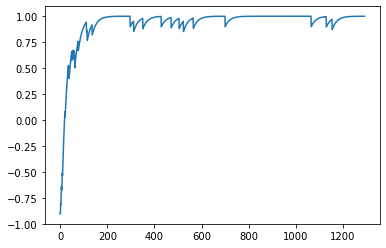

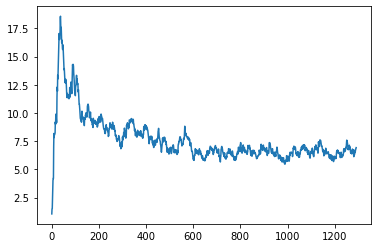

In [6]:
pi, v, scores, steps = REINFORCE_with_mean_baseline(LineWorld(), max_iter_count=10000)
print(pi.weights)
plt.plot(scores)
plt.show()
plt.plot(steps)
plt.show()